# Machine Learning Projekt - Gruppe 9
## Projekt: _Electric Motor Temperature Estimation_
### SS2025

Gruppenmitglieder: André Korten, Fynn Buhl, Kilian Feil, Lukas Quast, Nic Tusch, Tobias Weismantel
____

## Aufgabenstellung:

Aufgabe des Projekts ist es, auf Grundlage des vorliegenden Datensatzes die Temperatur des Permanentmagneten eines datas vorherzusagen.
Zur Umsetzung dieser Regressionsaufgabe werden zwei vorgegebene Verfahren eingesetzt: Random Forest sowie ANN. Zusätzlich wird ein drittes, selbst gewähltes Verfahren zur Modellierung und zum Vergleich herangezogen.




&nbsp;

---
### 1. Problemdefinition und Kontext

#### Zielsetzung (Objective)

Ziel des Projekts ist es, auf Basis der Messwerte von Spannung (`u_d`, `u_q`) und Strom (`i_d`, `i_q`) in dq-Koordinaten sowie weiterer verfügbarer Sensordaten (z. B. Drehmoment und Drehzahl) die Temperatur des Permanentmagneten (`pm`) vorherzusagen. Auf die Verwendung von Temperaturmesswerten benachbarter Motorbauteile soll dabei nach Möglichkeit verzichtet werden, da diese nicht in jeder Anwendung zwangsläufig zur Verfügung stehen. Ein präzises Temperaturmodell soll die frühzeitige Erkennung potenziell schädlicher Überhitzung ermöglichen, bevor reale Schäden auftreten, und ist damit ein wichtiger Baustein für eine vorausschauende Wartung und den Schutz des Motors.

**Business Objective:** Vermeidung von Leistungseinbussen Motorschäden durch rechtzeitiges Erkennen kritischer Temperaturen.

Die Literatur weist darauf hin, dass Abweichungen von etwa 10 % oberhalb etablierter Temperaturgrenzen zu gefährlichen Zuständen, Motorschäden oder erheblichen Leistungsminderungen führen können. Studien zeigen, dass präzise Temperaturprognosen mit einer Abweichung von weniger als 5 °C notwendig sind, um frühzeitig thermische Überlastungen zu erkennen und eine zuverlässige Lebensdauer der Permanentmagneten zu gewährleisten. Gängige Thermokoppler mit Industrieanwendung weisen eine Mess-Toleranz von ±2°C auf.

Daher wird der **Zielbereich für die zu untersuchenden ML-Modelle auf ±2 °C festgelegt**.

# TODO



#### Leistungsbewertung (Performance Criteria)

Zur Bewertung der Modellleistung wird die gebräuchliche Metrik für Regressionsaufgaben verwendet:

- **Root Mean Square Error (RMSE):** Betonung größerer Fehler, empfindlich gegenüber Ausreißern, gut geeignet, wenn starke Abweichungen kritisch sind.
- **Mean Absolute Error (MAE):** Durchschnittlicher Fehler, robuster gegenüber Ausreißern, liefert eine intuitive Interpretation („um wie viel Grad liege ich im Mittel daneben?“).

**Ziel:** Minimierung beider Werte, wobei RMSE als Hauptoptimierungsmetrik dient.



#### Lösungsansatz ohne Machine Learning

Bisher wird die Temperatur des Permanentmagneten mit Thermoelementen direkt am Prüfstand gemessen. In einem rein regelbasierten System könnten Grenzwerte überwacht und bei Überschreitung automatisch die Leistung gedrosselt werden. Alternativ wäre denkbar, einfache physikalische Modelle (z. B. basierend auf Energieverlusten durch Stromfluss, Wärmeübertragung und Umgebungstemperatur) zu verwenden, um Temperaturentwicklungen zu schätzen. Diese Modelle wären jedoch stark vereinfacht und schwer auf unterschiedliche Lastprofile übertragbar.



#### Annahmen (Assumtions)

- Supervised Learning: Es liegen gelabelte Trainingsdaten des Zielwerts `pm` vor.
- Offline / Batch Learning: Das Modell wird auf einem statischen Datensatz trainiert, da alle Daten in den Speicher passen und kein kontinuirlicher Datenstrom erwartet wird
- Univariate Regression: Nur ein Zielwert (`pm`) wird vorhergesagt.
- Multiple Regressions Aufgabe: Da mehrer Eingangsgrößen zur Vorhersage verwendet werden.
- Keine defekten Motorzustände im Datensatz vorhanden.
- Alle Daten sind numerisch, keine kategorialen Features.
- Die `profile_id` stellt unterschiedliche Testzyklen dar.   

In [1]:
# import required packages for the whole project
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import pprint 
from scipy import stats
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

---
### 2. Verwendeter Datensatz

#### Kontext

Der Datensatz enthält Sensormessdaten eines Permanentmagnet-Synchronmotors (PMSM), der auf einem Prüfstand betrieben wurde. Es handelt sich um einen Prototyp eines deutschen OEMs. Die Messungen wurden durch die Universität Paderborn durchgeführt.

#### Struktur

- **Samplingrate:** 2 Hz  
- **Messdauer:** 1 bis 6 Stunden je Session  
- **Sessions:** Unterscheidbar durch `profile_id`  
- **Lastprofil:** Zufällige Lastwechsel (random walk) zur realitätsnahen Simulation dynamischer Betriebszustände

#### Feature-Beschreibung

- **u_d, u_q:** Spannungen in d/q-Koordinaten (in V)  
- **i_d, i_q:** Ströme in d/q-Koordinaten (in A)  
- **motor_speed:** Motordrehzahl (in rpm)  
- **torque:** Drehmoment (in Nm)  
- **coolant, ambient, stator_winding, stator_tooth, stator_yoke:** Temperaturmessungen an verschiedenen Stellen (in °C)
- **pm:** Temperatur des Permanentmagneten (Zielgröße) (in °C)

Die d/q-Komponenten resultieren aus einem geregelten Antriebssystem, das Drehzahl und Moment möglichst genau an Referenzwerte anpasst.

Quelle:
[Electric Motor Temperature Dataset – Kaggle](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature)

#### Daten einlesen

Um den Datensatz effizient und flexibel laden zu können, wird eine eigene Ladefunktion definiert. Pfad und Dateiname können dabei unkompliziert angepasst werden.
Standardmäßig wird angenommen, dass die Datei eine Kopfzeile (Header) enthält. Dies trifft auch für den verwendetet Datensatz zu.

In [2]:
# Define the path where the data file is stored
DATA_PATH = "./"
CSV_FILE = "measures_v2.csv"

# Function to load motor data from a CSV file an retur an pandas DataFrame
def load_motor_data(data_path=DATA_PATH, filename=CSV_FILE):
    csv_path = os.path.join(data_path, filename) #CSV file has a header row -> Default: Assumes that the first row is the header
    return pd.read_csv(csv_path)

# Load the motor dataset using the defined function
data = load_motor_data(DATA_PATH, CSV_FILE)

# Display information about the loaded DataFrame, to briefly validate a succseful import
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


#### Erster Überblick über den Datensatz

Der Befehl `data.info()` gibt einen kompakten Überblick über den geladenen DataFrame. Damit lassen sich grundlegende Eigenschaften des Datensatzes überprüfen:

- **Anzahl der Einträge:**  
  `RangeIndex: 1330816 entries, 0 to 1330815`  
  → Der Datensatz enthält ca. **1,33 Millionen Zeilen**, ist also recht umfamgreich.

- **Spaltenanzahl und Datentypen:**  
  `total 13 columns`, davon `12 x float64`, `1 x int64`  
  → Es liegen ausschließlich **numerische Daten** vor, keine Strings oder kategorischen Variablen  – ein Preprocessing-Schritt zum Encoden ist nicht nötig.

- **Fehlende Werte:**  
  `Non-Null Count` ist in jeder Spalte gleich der Gesamtanzahl der Zeilen (1330816)  
  → **Es gibt keine fehlenden Werte** – ein Preprocessing-Schritt zum Auffüllen (`fillna`) ist nicht nötig.

- **Speicherauslastung:**  
  `memory usage: 132.0 MB`  
  → Die Datenmenge ist überschaubar und kann im RAM verarbeitet werden (Batch Learning möglich).


Um einen ersten Endruck über die Sturktur des datensatzes zu bekommen werden mit `data.head()` die ersten Zeilen des Datensatztes und mit `data.describe()` eine statistiche Zusammenfassung ausgegeben:

In [3]:
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [4]:
data.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


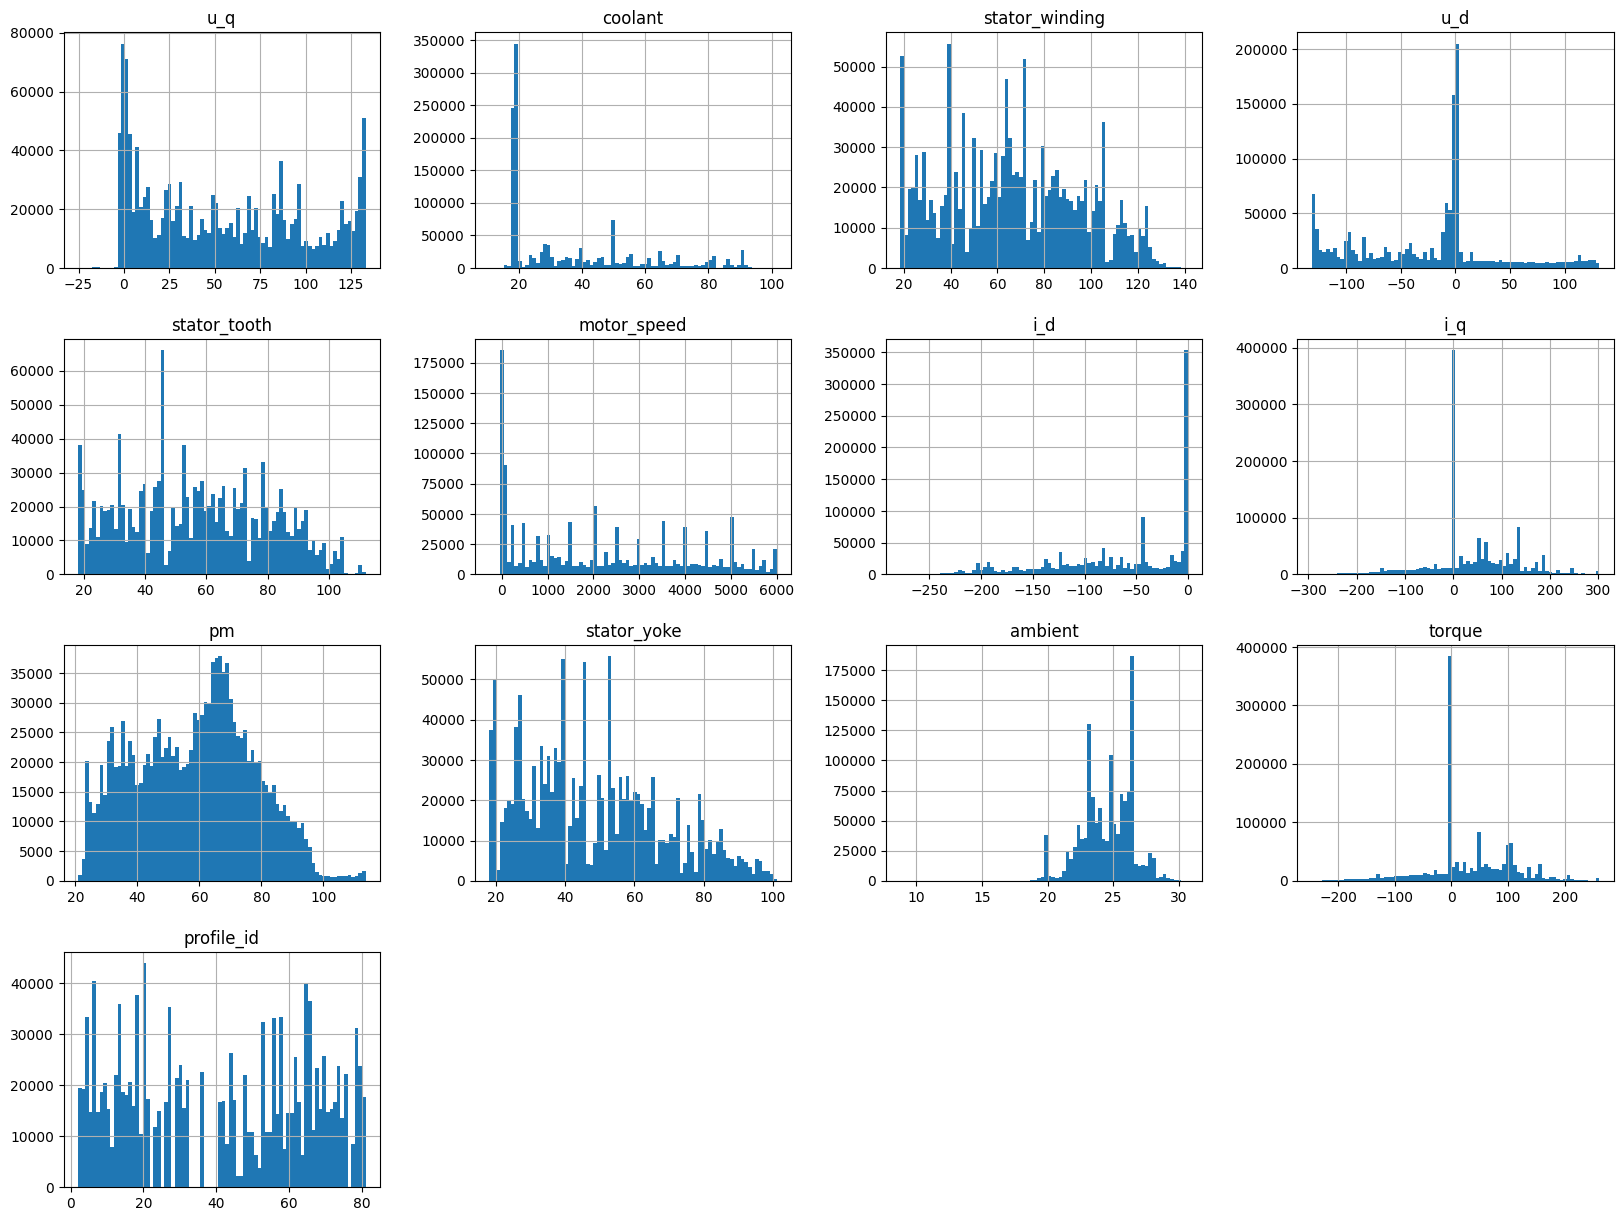

In [5]:
# Plots histograms for all features.
# Useful for detecting outliers, distribution shapes, and scale differences.
data.hist(bins=80, figsize=(20,15)) 
plt.show()

**Zentrale Erkenntnisse:**


- **Größenordnung der Messwerte & Einheiten passen:**  
  Alle Messwerte befinden sich in sinnvollen physikalischen Größenbereich.

- **Histogramme zeigen für die meisten Features eine annähernd Normalverteilung.**

- **Skalierung der Features variiert stark:**
  - `motor_speed`: Ø ≈ 2200, max ≈ 6000
  - `coolant`, `ambient`, `pm`: typischer Temperaturbereich 10–110 °C
  - `i_q`: zwischen -293 und +301 → hohe Dynamik in der Stromregelung
  - `u_d`: reicht von -131 bis +131 → symmetrische Verteilung
  → **Feature Scaling** ist notwendig für viele ML-Modelle.

- **Negative Werte bei `torque`, `i_q`, `i_d`, `u_d`, `u_q`.**

- **`profile_id`:**
  - Wertebereich: 2 bis 81
  - → nicht alle IDs sind vergeben.

- **Zielvariable `pm` (Permanentmagnet-Temperatur):**
  - Mittelwert: 58,5 °C
  - Minimum: 20,9 °C
  - Maximum: 113,6 °C
  → kein extremer Ausreißerbereich.

- **Hohe Anzahl 0-naher Werte**:
  - Besonders bei den Features `motor_speed`, `torque`, `i_q`, `i_d`, `u_d` und `u_q` fällt die hohe Anzahl 0-naher Werte auf. Später soll daher überprüft werden ob dieses ungleichgewicht der Messwertverteilung einen negativen Einfluss uaf die ML-Modelle hat und entsprechende Zeilen ggf. aus dem Datensatz entfernt werden sollten.

#### Trainings- und Testset erstellen

Um sicherzustellen, dass alle Messsessions (`profile_id`) im Trainings- und Testdatensatz proportional vertreten sind, wird ein **stratifiziertes Sampling** durchgeführt. Dadurch bleibt die Verteilung der Messsessions in beiden Datensätzen erhalten, was Über- oder Unterrepräsentation einzelner Sessions vermeiden und die Generalisierbarkeit des Modells verbessern soll.

Da der Datensatz sehr groß ist (~1,3 Mio. Einträge), reicht ein Testset mit **1% der Daten** aus, um valide Modellevaluationen durchzuführen (vgl. Vorlesung).

count    1.330816e+06
mean     4.079306e+01
std      2.504549e+01
min      2.000000e+00
25%      1.700000e+01
50%      4.300000e+01
75%      6.500000e+01
max      8.100000e+01
Name: profile_id, dtype: float64


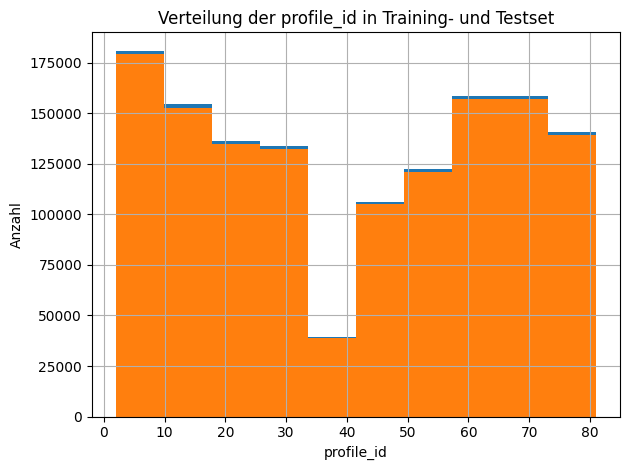

In [6]:
# sample a stratified test set from all sessions (multiple measurements can be distinguished from each other by column profile_id)
print(data["profile_id"].describe())


# Testsetsize = 1%, due to more then 100000 Datapoints
split = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)
for train_index, test_index in split.split(data, data["profile_id"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]


# Verify that the stratified test set (orange) preserves the same distribution shape as the full dataset (blue), 
# but with ~99% of the sample size (lower bars with identical relative frequencies).   
data["profile_id"].hist()    
strat_train_set["profile_id"].hist()
plt.title(f"Verteilung der profile_id in Training- und Testset")
plt.xlabel("profile_id")
plt.ylabel("Anzahl")
plt.grid(True)
plt.tight_layout()
plt.show()

---
### 3. Datenexploration

#### Verteilung der Zielvgröße `pm` - Permanetmagnet-Temeperatur

Die Verteilung der Zielgröße `pm` wird als Histogramm mit Dichtekurve dargestellt.  
Dies hilft, mögliche Schieflagen, Ausreißer oder Auffälligkeiten zu erkennen.

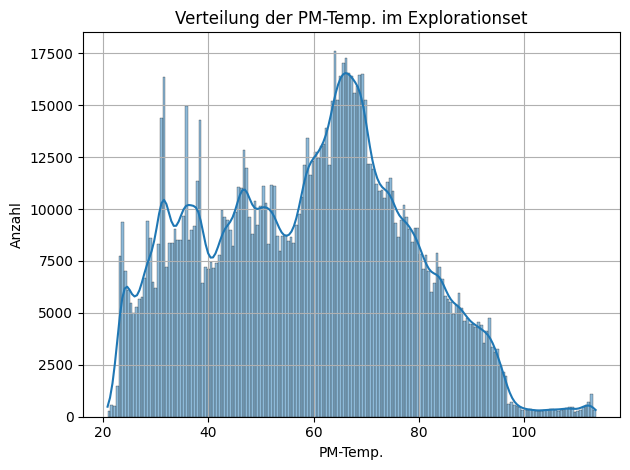

In [7]:
# Create a histogram of the 'pm' column from the 'exploration_set' DataFrame.
# Shows the distributions, skewness for target variable (pm).
# The KDE provides a smoothed representation of the data's distribution.
sns.histplot(strat_train_set['pm'], kde=True)
plt.title(f"Verteilung der PM-Temp. im Explorationset")
plt.xlabel("PM-Temp.")
plt.ylabel("Anzahl")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# show statistical data for target value
strat_train_set['pm'].describe()

count    1.317507e+06
mean     5.850678e+01
std      1.900084e+01
min      2.085696e+01
25%      4.315026e+01
50%      6.026770e+01
75%      7.200910e+01
max      1.136066e+02
Name: pm, dtype: float64

Der Großteil der Messwerte zeigt, dass der Magnet am häufigsten in einem Bereich von **60 bis 70 °C** betrieben wird, was den typischen Hauptbetriebszustand widerspiegelt. Eine weitere Konzentration der Messungen liegt bei **25 bis 35 °C** und **45 bis 55 °C**, was auf Phasen mit geringerer Last oder Leerlauf hindeutet.

Die Durchschnittstemperatur beträgt 58,51 °C, mit einer Standardabweichung von 19 °C wird die Streuung der Temperaturen als gering/moderat eingestuft.

#### Erstellung eines kompakten Explorations-Datensatzes

Für die weitere explorative Datenanalyse wird ein kleiner, aber repräsentativer Ausschnitt aus dem Trainingsdatensatz benötigt. Ziel ist es, einfache Analysen, Visualisierungen und Vorverarbeitungsschritte schnell und ressourcenschonend durchzuführen – ohne direkt auf den vollständigen Trainings-Datensatz zugreifen zu müssen.

Dazu werde mittels **stratifiziertem Sampling** 20% des Trainingsdatensatzes ausgewählt, wobei die Verteilung der unterschiedlichen Messsessions (`profile_id`) beibehalten wird.

In [9]:
# copy the training set for exploration
data_exploration = strat_train_set.copy()

# sample the exploration_set down to ~20% of the original trainingset for easy and fast exploration
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for _, exploration_index in split.split(data_exploration, data_exploration["profile_id"]):
    exploration_set = data_exploration.iloc[exploration_index].copy()
    

exploration_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263502 entries, 1636 to 323786
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   u_q             263502 non-null  float64
 1   coolant         263502 non-null  float64
 2   stator_winding  263502 non-null  float64
 3   u_d             263502 non-null  float64
 4   stator_tooth    263502 non-null  float64
 5   motor_speed     263502 non-null  float64
 6   i_d             263502 non-null  float64
 7   i_q             263502 non-null  float64
 8   pm              263502 non-null  float64
 9   stator_yoke     263502 non-null  float64
 10  ambient         263502 non-null  float64
 11  torque          263502 non-null  float64
 12  profile_id      263502 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 28.1 MB


#### Korrelationsanalyse

Mit der Korrelationsmatrix wird untersucht, wie stark die einzelnen Features mit der Zielgröße `pm` (Permanentmagnet-Temperatur) zusammenhängen.  
Das Sortieren der Korrelationen nach `pm` zeigt, welche Messgrößen den größten Einfluss auf die Temperatur haben und damit für das Modell besonders relevant sein könnten. Dies wird unten zusätzlich grafisch als Heatmap dargestellt.

In [10]:
# calcutale correlation matrix
corr_matrix = exploration_set.corr()

# look at how much each attribute correlates with the pm temp:
corr_matrix["pm"].sort_values(ascending=False)

pm                1.000000
stator_tooth      0.832329
stator_winding    0.796250
stator_yoke       0.757200
ambient           0.514605
coolant           0.467733
motor_speed       0.459339
profile_id        0.386073
u_q               0.121543
torque           -0.118263
i_q              -0.143676
u_d              -0.170843
i_d              -0.429555
Name: pm, dtype: float64

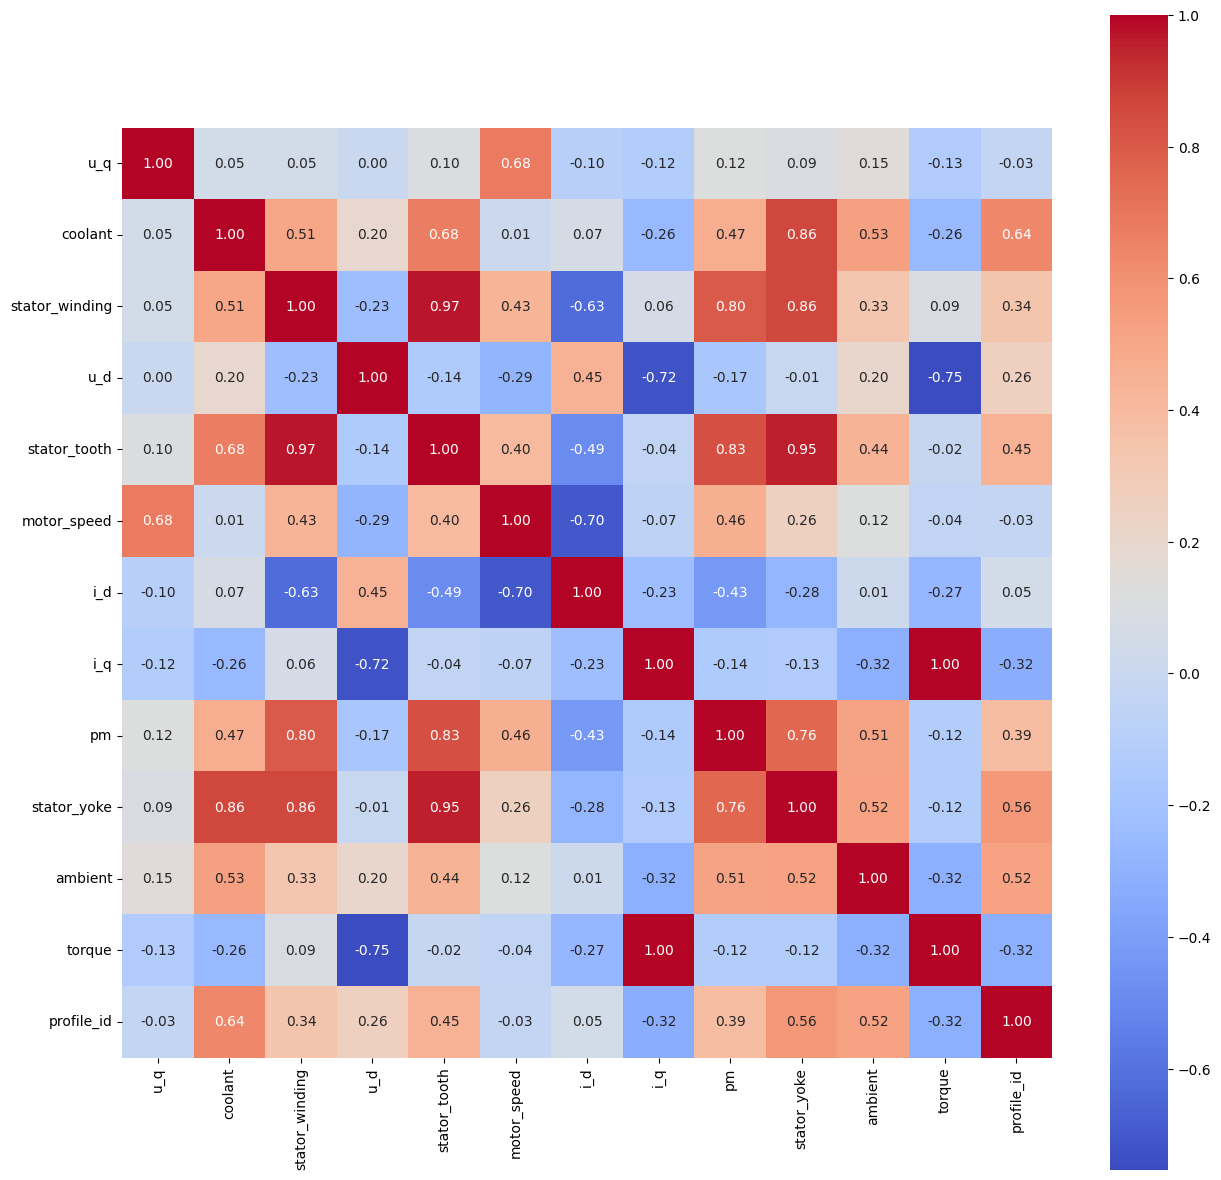

In [11]:
# Plot correlation matrix as a heatmap
# Annotate cells with correlation values, formatted to two decimals
# Use 'coolwarm' color map to highlight positive and negative correlations
# Set figure size and enforce square cells for better readability
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.show()

Die Analyse zeigt, dass die Temperaturen an verschiedenen Motorteilen sehr stark mit der Permanentmagnet-Temperatur (`pm`) korrelieren:  
- Besonders hohe positive Korrelationen haben `stator_tooth` (0,83), `stator_winding` (0,80) und `stator_yoke` (0,76).  
- Die Umgebungs- (`ambient`, 0,51) und Kühlwassertemperatur (`coolant`, 0,47) zeigen moderate positive Zusammenhänge.  

Auf die Verwendung von Temperaturmesswerten benachbarter Motorbauteile soll jedoch verzichtet werden, da diese nicht in jeder Anwendung zwangsläufig zur Verfügung stehen.

- die Motordrehzahl `motor_speed` korrelieren (0,46) ebenfalls positiv, wenn auch schwächer.  

Spannungen und Ströme weisen geringe bis mäßige negative Korrelationen auf, z. B. `i_d` (-0,43), was auf komplexere Einflüsse oder Gegenläufigkeiten hindeutet.

Die Korrelation von 0,39 zwischen `pm` und `profile_id` zeigt zwar einen gewissen Zusammenhang, aber `profile_id` ist eigentlich nur ein Identifikator für verschiedene Messsessions. Dieser Wert (0,39) spiegelt also keine physikalische Beziehung wider, sondern eher, dass unterschiedliche Messungen (Sessions) unterschiedliche Temperaturniveaus haben können. Für die Modellierung ist `profile_id` daher eher kein sinnvoller Prädiktor.

Die Motordrehzahl (`motor_speed`) ist eine zentrale Betriebsgröße, die mechanische Belastung und thermische Zustände beeinflusst (siehe Korrelation zu `pm`).  
Die Analyse der Korrelationen mit `motor_speed` identifiziert relevante Einflussgrößen und unterstützt die Auswahl signifikanter Features für die Modellierung.  

In [12]:
# look at how much each attribute correlates with the motor_speed:
corr_matrix["motor_speed"].sort_values(ascending=False)

motor_speed       1.000000
u_q               0.682638
pm                0.459339
stator_winding    0.432177
stator_tooth      0.398794
stator_yoke       0.256433
ambient           0.119980
coolant           0.012453
profile_id       -0.028454
torque           -0.043939
i_q              -0.068786
u_d              -0.287561
i_d              -0.701217
Name: motor_speed, dtype: float64

Die Motordrehzahl (`motor_speed`) zeigt starke positive Korrelationen mit den elektrischen Größen `u_q` (0,68) und eine starke negative Korrelation mit `i_d` (-0,70).  

Auch die Permanentmagnet-Temperatur (`pm`) sowie Temperaturen an Wicklung (`stator_winding`) und Zahn (`stator_tooth`) korrelieren (wie erwartet) moderat positiv mit der Drehzahl.  

#### Daten Visualisierung

Der folgende Pairplot visualisiert die paarweisen Zusammenhänge zwischen den zentralen physikalischen Merkmalen des Motors: `u_q`, `i_q`, `motor_speed`, `torque` und `pm`.  
Diese Merkmale wurden ausgewählt, da sie direkt die elektrische Ansteuerung (`u_q`, `i_q`), das Betriebsverhalten (`motor_speed`, `torque`) und dem thermischen Zustand (`pm`) des Motors verknüpfen.


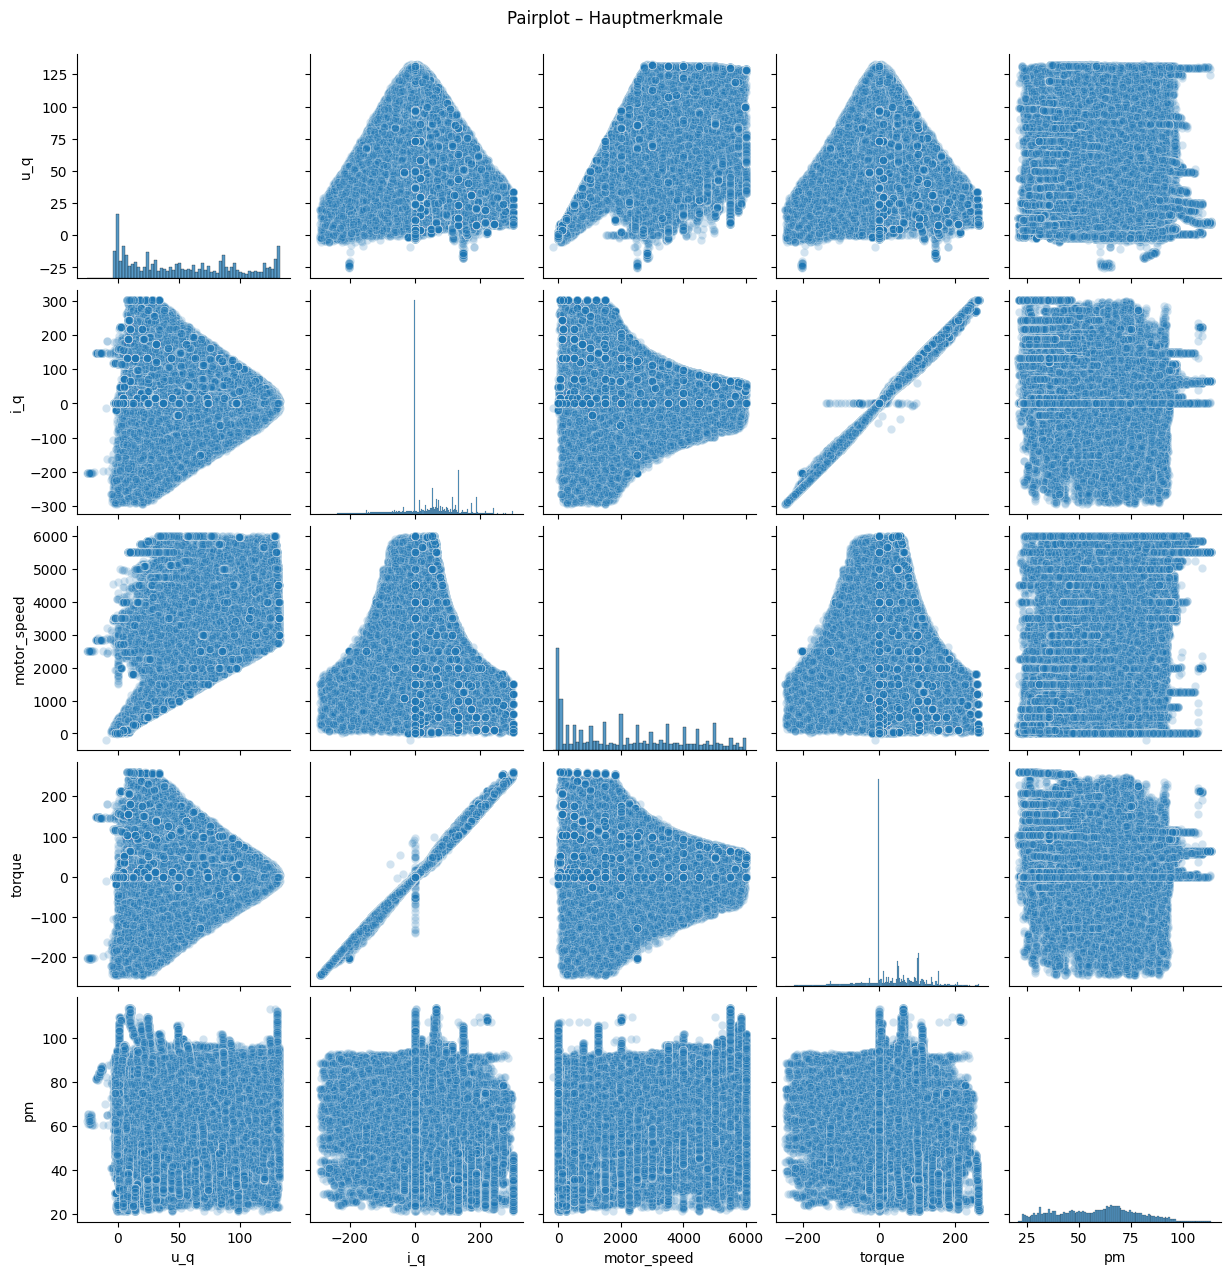

In [13]:
# Pairplot with selected main features
features_to_plot = ['u_q', 'i_q', 'motor_speed', 'torque', 'pm']
sns.pairplot(exploration_set[features_to_plot], plot_kws={'alpha':0.2})
plt.suptitle("Pairplot – Hauptmerkmale", y=1.02)
plt.show()

Die visualisierten Merkmale (`u_q`, `i_q`, `motor_speed`, `torque`, `pm`) zeigen wie erwartet die physikalischen Zusammenhänge:

- **`i_q` und `torque`** korrelieren stark positiv, was die direkte Abhängigkeit des Drehmoments vom q-Achsen-Strom bestätigt.
- **`motor_speed` vs. `torque`** zeigt eine typische inverse Beziehung bei konstantem Lastmoment – ein erwarteter Effekt aus dem stationären Betrieb.
- **`u_q` hängt sowohl mit `i_q` als auch mit `motor_speed` zusammen**, da Spannung, Strom und Drehzahl über die Spannungsdifferenzgleichung verknüpft sind.

Zusätzlich wurden die **Verteilungen und Boxplots der einzelnen Merkmale** separat nebeneinander dargestellt.  
Dadurch lassen sich Schiefe, Ausreißer und Dichtebereiche der Messdaten untersuchen.

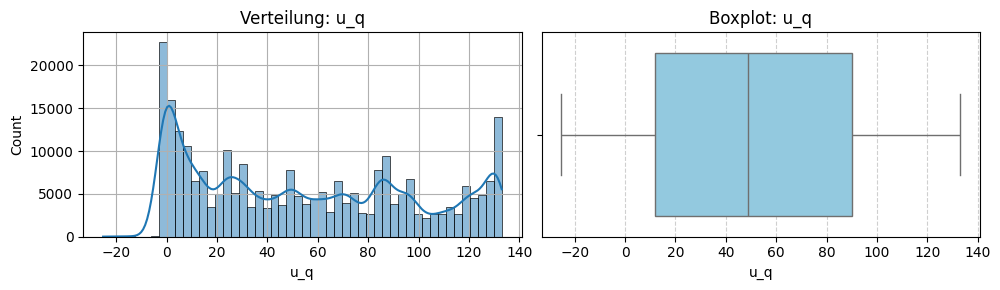

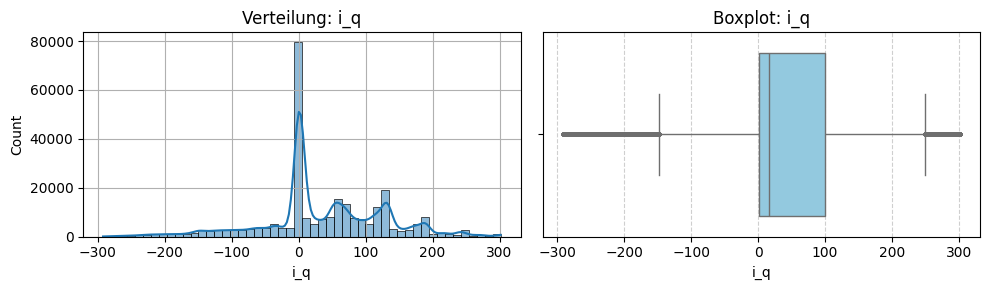

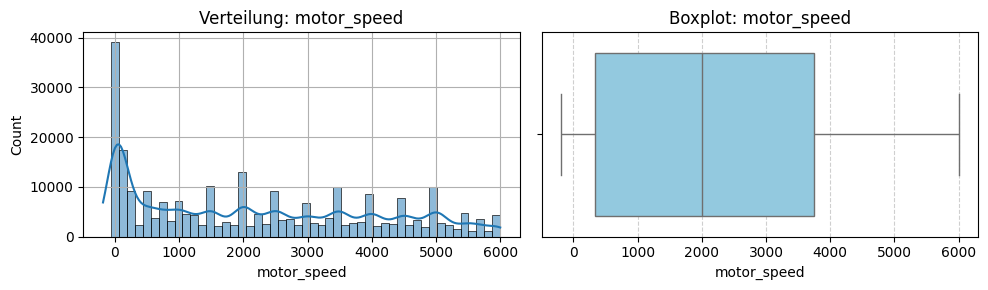

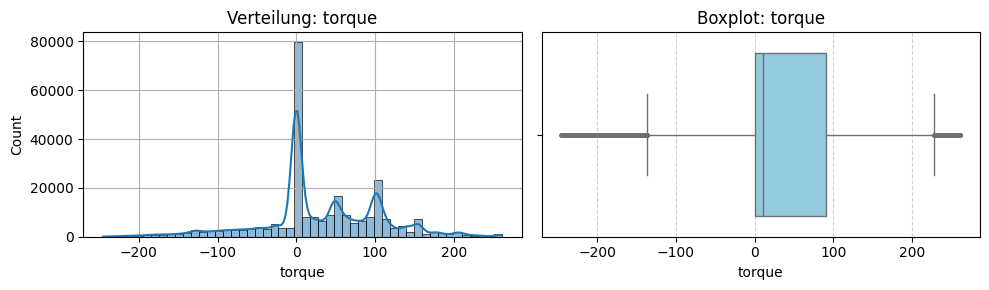

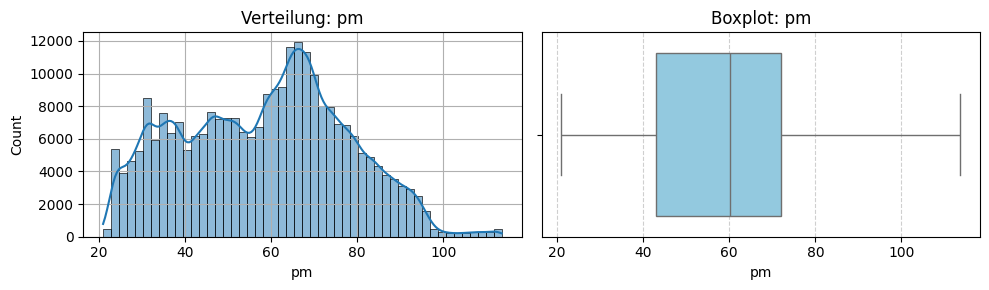

In [14]:
for col in features_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Dsitribution
    sns.histplot(exploration_set[col], kde=True, bins=50, ax=axes[0])
    axes[0].set_title(f"Verteilung: {col}")
    axes[0].grid(True)

    # Boxplot
    sns.boxplot(x=exploration_set[col], color='skyblue', fliersize=2, ax=axes[1])
    axes[1].set_title(f"Boxplot: {col}")
    axes[1].grid(True, axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

Auch in der Visulaliserung der Hauptmerkmale sind keine Ausreißer oder besondere Schieflagen zu erkennen. 

#### Neue Attribut-Kombinationen

Abgeleitet aus den obigen Erkenntnissen und zur Erweiterung der Merkmalsbasis wird zunächst die elektrische Leistung (`power`) als neue Variable berechnet:

In [15]:
# Calculate the power and store it in a new 'power' column and calculate the correlation matrix with all other attributes
exploration_set["power"] = exploration_set["u_d"] * exploration_set["i_d"] + exploration_set["u_q"] * exploration_set["i_q"]
corr_matrix = exploration_set.corr()
corr_matrix["power"].sort_values(ascending=False)

power             1.000000
torque            0.755165
i_q               0.717492
motor_speed       0.280462
stator_winding    0.265565
pm                0.183579
stator_tooth      0.163777
stator_yoke       0.020200
u_q              -0.048766
coolant          -0.198643
ambient          -0.209536
profile_id       -0.253222
i_d              -0.487094
u_d              -0.992356
Name: power, dtype: float64

Die starke positive Korrelation zu `torque` (0,75) und `i_q` (0,72) bestätigt physikalisch erwartete Zusammenhänge. Allerdings zeigt `power` nur eine schwache positive Korrelation mit der Zielgröße `pm` (0,18), was auf eine begrenzte Aussagekraft der Leistung als Prädiktor für die Magnettemperatur hinweist.
Aufgrund dieser geringen Relevanz wird die Leistung als Feature für das Modell nicht weiter verfolgt.

Im nächsten Schritt erfolgt eine Untersuchung der **Stromstärke (current magnitude)** als möglicher aussagekräftigerer Prädiktor:

In [16]:
# Calculate the current magnitude and store it in a new 'current_magnitude' column and calculate the correlation matrix with all other attributes
exploration_set["current_magnitude"] = np.sqrt(exploration_set["i_d"]**2 + exploration_set["i_q"]**2)
corr_matrix = exploration_set.corr()
corr_matrix["current_magnitude"].sort_values(ascending=False)

current_magnitude    1.000000
stator_winding       0.573639
stator_tooth         0.420845
torque               0.397854
power                0.395944
motor_speed          0.383412
i_q                  0.373940
pm                   0.254592
stator_yoke          0.235736
u_q                 -0.014798
ambient             -0.052355
profile_id          -0.081115
coolant             -0.089711
u_d                 -0.354021
i_d                 -0.845792
Name: current_magnitude, dtype: float64

Die Korrelationsanalyse zeigt positive Zusammenhänge mit `torque` und `motor_speed`. Die Korrelation mit der Zielvariable `pm` ist mit 0,25 aber nicht sehr hoch.

Allerdings korreliert `current_magnitude` moderat positive mit den Temperaturen von Wicklung (`stator_winding`, 0,57) und Zahn (`stator_tooth`, 0,42), welche wiederum stark mit der Zielvariable korrelieren.

Diese Ergebnisse deuten darauf hin, dass die Stromstärke ein relevanter Einflussfaktor für die Temperaturentwicklung im Motor sein könnte und somit als Feature in die Modellierung aufgenommen werden sollte.

#### Daten Bereinigung

Das untenstehende Diagramm zeigt die Verteilung von `motor_speed` im Intervall [-0.1, 0.1]. Es macht sichtbar, wie stark dieses Feature um den Nullpunkt konzentriert ist. Die Visualisierung soll die Auswahl eines sinnvollen Schwellenwerts (`interval`) für den `ZeroCloseValueFilter` Transformer unterstüzen.

Ziel: Ggf. Zeilen mit 0-nahen Werten gezielt entfernen, um mögliche Verzerrungen im Modelltraining zu vermeiden.

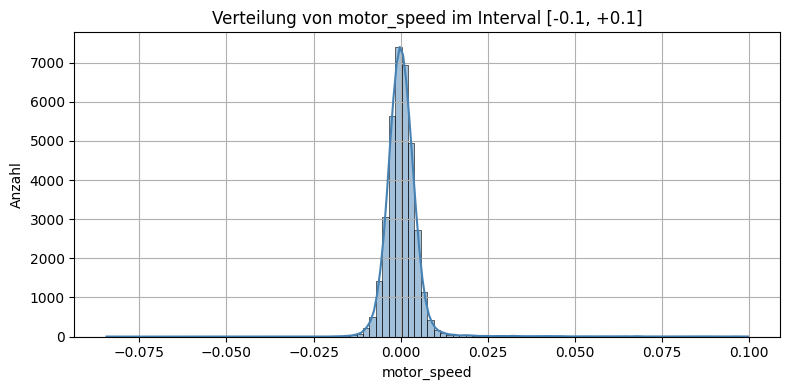

In [17]:
# Define interval
x = 0.1

# Filter data where motor_speed is in the interval [-x, +x]
ud_near_zero = exploration_set.query(f"abs(motor_speed) <= {x}")

# Plot
plt.figure(figsize=(8, 4))
ax = sns.histplot(ud_near_zero["motor_speed"], bins=100, kde=True, color="steelblue")
plt.title(f"Verteilung von motor_speed im Interval [-{x}, +{x}]")
plt.xlabel("motor_speed")
plt.ylabel("Anzahl")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Test: Entfernen 0-naher Messwerte aus dem Datensatz

In diesem Schritt wird getestet, ob sich das Entfernen von Messwerten mit sehr kleinen Absolutwerten positiv auf die Performance der ML-Modelle auswirkt.  
Der Filter wird testweise angewendet. Die zugehörigen Zielwerte (`pm`) werden dabei synchron mitgefiltert, um die Datenintegrität zu wahren.  
Später kann untersucht werden, ob dieser Vorverarbeitungsschritt die Modellgüte verbessert oder nicht.


In [18]:
# Filter out all rows from the dataset where any of the key electrical features 
# (motor_speed, i_q, i_d, u_d, u_q) are within a near-zero interval around 0. 
# Define filter parameters
cols_to_check = ["motor_speed", "i_q", "i_d", "u_d", "u_q"]
interval = 0.01  # Value estimated from data exploration

# Filter out rows where any of the selected features are near zero
mask = (exploration_set[cols_to_check].abs() > interval).all(axis=1)

# Apply mask to both features and labels
motor_filtered = exploration_set[mask].reset_index(drop=True)

# Print dataset size comparison
print("Rows before filtering:", len(exploration_set))
print("Rows after filtering:", len(motor_filtered))
print("Rows removed:", len(exploration_set) - len(motor_filtered))

Rows before filtering: 263502
Rows after filtering: 228884
Rows removed: 34618


*__Nachtrag:__* Es zeigte sich, dass ein entfernen 0-naher Messwerte keinen erkennbaren Einfluss auf die Vorhersage-Performance hat. Deswegen wird dieser Schritt nicht weiter verfolgt.

---
### 4. Daten Vorbereitung



Im nächsten Schritt wird eine  Kopie des Trainingsdatensatzes (`strat_train_set`) erzeugt, damit das Originaldataset unverändert bleit.
Darauf aufbauend werden die Features vom Zielwert getrennt. Die Zielvariable `pm` wird als eigene Serie (`motor_pm_labels`) extrahiert, während die Trainingsdaten ohne `pm` als Eingabedaten (`motor`) verbleiben.  

In [19]:
# Prepare the target labels by copying the 'pm' column
motor_pm_labels = strat_train_set["pm"].copy()

# Prepare the feature set by dropping the target column 'pm' for training
motor = strat_train_set.drop("pm", axis=1)

* Im Datensatz sind keine fehlenden Werte vorhanden, daher ist keine Datenimputation notwendig.  
* Da alle Features numerisch sind, ist kein Encoding kategorialer Variablen erforderlich.

#### Transformer

Ziel ist die Vorhersage der Permanentmagnet-Temperatur (`pm`) auf Basis elektrischer Größen wie Spannung (`u_d`, `u_q`) und Strom (`i_d`, `i_q`) sowie mechanischer Größen wie Drehmoment und Drehzahl. Temperaturdaten benachbarter Bauteile sollen bewusst außen vor bleiben, da diese nicht in jeder Anwendung zwangsläufig zur Verfügung stehen. Das entfernen dieser Features kann jedoch als Hyperparameter `drop_selected_features` gesteuert werden.

Die `profil_id` ist kein allgemeingültiger Parameter und soll nicht zur Schätzung der PM-Temperatur genutzt werden. Daher wird sie immer entfernt.

In [20]:
# Custom transformer to drop selected features from the dataset
# Always drop 'profile_id'
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, drop_temp_features=True):
        self.drop_temp_features = drop_temp_features
        self.features_to_drop = [
            "coolant", 
            "stator_winding", 
            "stator_tooth", 
            "stator_yoke", 
            "ambient"
        ]

    def fit(self, X, y=None):
        # No fitting necessary
        return self

    def transform(self, X):
        # Always drop 'profile_id'
        X = X.drop(columns=["profile_id"])
        
        # If dropping is disabled, return original data unchanged
        if not self.drop_temp_features:
            return X

        # Drop specified columns if they exist
        return X.drop(columns=[f for f in self.features_to_drop if f in X.columns])
    
# Instantiate transformer with dropping enabled for manual testing
dropper = FeatureDropper(drop_temp_features=True)
motor_reduced = dropper.transform(motor)

motor_reduced.head()


,u_q,u_d,motor_speed,i_d,i_q,torque
486400,73.499413,-0.246484,1499.983521,-2.000962,1.097150,-2.366589e-02
724527,70.820196,-3.026034,1495.647860,-2.659218,4.360475,2.173315e+00
641872,-0.174199,3.290139,0.002076,-2.000971,1.097257,-1.603729e-211
108384,4.176036,1.483652,99.974022,-1.999888,1.095639,2.330701e-01
882919,107.053965,-76.085422,3499.971770,-74.765850,61.168734,5.000000e+01


Es soll das neue Feature `current_magnitude` aus den Voruntersuchungen ergänzt werden:
Dazu wird ein Transformer der Klasse `CurrentMagnitudeAdder` implementiert, der als Teil der Datenvorverarbeitung die Stromstärke berechnet und als neue Spalte an den Datensatz anhängt.  
Der Transformer enthält den Hyperparameter `add_current_magnitude`, mit dem gesteuert werden kann, ob das neue Feature current_magnitude hinzugefügt wird oder nicht.

In [21]:
# Custom transformer to add a new feature 'current_magnitude' to the dataset
class CurrentMagnitudeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_current_magnitude=True):
        self.add_current_magnitude = add_current_magnitude

    def fit(self, X, y=None):
        # No fitting necessary
        return self

    def transform(self, X):
        # If feature addition is disabled, return original data unchanged
        if not self.add_current_magnitude:
            return X

        # Calculate current magnitude as sqrt(i_d^2 + i_q^2) and add as new column
        current_magnitude = np.sqrt(X["i_d"]**2 + X["i_q"]**2)
        return X.assign(current_magnitude=current_magnitude)


# Instantiate transformer with feature addition enabled for manual testing
attr_adder = CurrentMagnitudeAdder(add_current_magnitude=True)
motor_extra_attribs = attr_adder.transform(motor)
motor_extra_attribs.head()


,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,stator_yoke,ambient,torque,profile_id,current_magnitude
486400,73.499413,18.620235,23.520418,-0.246484,23.678951,1499.983521,-2.000962,1.097150,21.984486,23.888302,-2.366589e-02,8,2.282013
724527,70.820196,28.859377,79.982515,-3.026034,65.189878,1495.647860,-2.659218,4.360475,50.937160,26.384446,2.173315e+00,53,5.107365
641872,-0.174199,79.659683,70.842393,3.290139,70.861331,0.002076,-2.000971,1.097257,72.114404,26.602693,-1.603729e-211,74,2.282073
108384,4.176036,18.453747,19.713879,1.483652,19.082251,99.974022,-1.999888,1.095639,18.994600,21.466301,2.330701e-01,2,2.280346
882919,107.053965,86.091312,96.735314,-76.085422,91.334451,3499.971770,-74.765850,61.168734,86.857632,25.000909,5.000000e+01,45,96.599929


#### Transformations Pipeline

Da alle Features numerisch sind und sequenzeill abgearbeitet werden, genügt eine einfache Pipeline. Ein ColumnTransformer wäre nur nötig, wenn unterschiedliche Spalten unterschiedliche Vorverarbeitungen brauchen.

Um Probleme aufgrund unterschiedlicher Größenordnungen der Features auszuschließen werden alle Daten am Ende der Pipeline standatisert skaliert.

In [22]:
pipeline = Pipeline([
        ('feature_dropper', FeatureDropper()), # Drops profil_id & temperature features, estimation should not be based on other temperatures
        ('magnitude_attrib_adder', CurrentMagnitudeAdder()), # Add custom feature 'current_magnitude'       
        ('std_scaler', StandardScaler()), # Scale all Features based on std
        ('regressor', None) # Placeholder
    ])


# Fit pipeline on training data and apply transformations
motor_prepared = pipeline.fit_transform(motor)

# Display transformed feature matrix for verification
motor_prepared

array([[ 0.43507932,  0.39452672, -0.37756506, ..., -0.39407429,
        -0.40368545, -1.23465936],
       [ 0.37442551,  0.35047052, -0.37989646, ..., -0.35867176,
        -0.375202  , -1.20152056],
       [-1.23279068,  0.45058261, -1.18414738, ..., -0.39407313,
        -0.40337863, -1.23465867],
       ...,
       [ 0.73590829, -1.15215377,  1.50446415, ...,  0.18073308,
         0.21235643,  0.42000173],
       [-0.62456304,  2.4282627 ,  0.92006705, ..., -1.66277996,
        -1.8352856 ,  1.3077355 ],
       [-1.21763315,  0.43986756, -1.18414654, ..., -0.39407543,
        -0.40337863, -1.23465869]], shape=(1317507, 7))

---
### 5. Modell-Training

#### Untersuchte Modelle

Neben dem `Random Forest` (nichtlinear, robust, bildlich vorstellbar) und einem neuronalen Netz `ANN` (leistungsstark, aber komplex) wird als drittes Modell eine `lineare Regression` gewählt.

*Begründung:*
Die lineare Regression dient als Baseline-Modell: Sie ist einfach, schnell trainiert und gut interpretierbar. So lässt sich nachvollziehen, ob komplexere Modelle wie ANN oder Random Forest tatsächlich einen Mehrwert bieten oder ob bereits eine lineare Beziehung ausreicht.



#### Modellbewertung mittels n-fold cross-validation

Die Funktion `evaluate_model_crossFold` soll die objektive Evaluierung aller untersuchten Regressionsmodellen durch **n-fold cross-validation** ermöglichen. Dabei wird das Modell mehrfach auf unterschiedlichen Trainings- und Validierungssplits getestet, um Überanpassung zu vermeiden und die Verallgemeinerungsfähigkeit zuverlässig abzuschätzen.

Die verwendeten Modell-Parameter wurden zuerst geschäzt und anschlißend in mehreren Iterationsschleifen angepasst. 

Die verwendete Bewertungsmetrik ist der **Root Mean Squared Error (RMSE)**, der die durchschnittliche Vorhersageabweichung quantifiziert und insbesondere größere Fehler stärker gewichtet. Die Funktion liefert neben den einzelnen RMSE-Werten der Folds auch deren Mittelwert und Standardabweichung zurück, um die Performance stabil und vergleichbar über verschiedene Modelle zu bewerten.

Als zweite Bewertungsmetrik wird der **Mean Absolute Error (MAE)** verwendet um die tatsächliche Abweichung in °C einschätzen zu können.

In [23]:
def evaluate_model_crossFold(model, training_features, training_labels, cv=5, display=False):
    """
    Evaluate a regression model using k-fold cross-validation (default: 5-fold).    
    Computes both Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)

    Parameters:
    - model: the regression model to evaluate
    - training_features: preprocessed training features
    - training_labels: training labels
    - cv: number of cross-validation folds (default: 10)
    - display: if True, prints scores and statistics
    
    Returns:
    - Dictionary with RMSE & MAE scores, mean, and standard deviation  
    """
    
    # RMSE
    scores = cross_val_score(model, training_features, training_labels, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
 
    
    # MAE
    neg_mae_scores = cross_val_score(model, training_features, training_labels, scoring="neg_mean_absolute_error", cv=cv)
    mae_scores = -neg_mae_scores

    results = {
        "rmse_scores": rmse_scores,
        "mean_rmse": rmse_scores.mean(),
        "std_rmse": rmse_scores.std(),
        "mae_scores": mae_scores,
        "mean_mae": mae_scores.mean(),
        "std_mae": mae_scores.std()
    }

    if display:
        print("RMSE scores:", results["rmse_scores"])
        print("Mean RMSE  :", results["mean_rmse"])
        print("Std RMSE   :", results["std_rmse"])
        print("MAE scores  :", results["mae_scores"])
        print("Mean MAE    :", results["mean_mae"])
        print("Std MAE     :", results["std_mae"])

    return results

#### Modell 1: Lineare Regression als Baseline

In [24]:
# Instantiate a linear regression model
lin_reg = LinearRegression()

# Train the model on the preprocessed training data and target labels
lin_reg.fit(motor_prepared, motor_pm_labels)

LinearRegression()

Zur Kontrolle wird die vollständige Preprocessing-Pipeline auf einige wenige Trainingsdaten angewendet. Um ein erstes Gefühl für die Modellgüte zu bekommen, werden die vorhergesagten Werte (`Predictions`) werden den tatsächlichen Werten (`Actual Labels`) gegenübergestellt.

In [25]:
# try the full preprocessing pipeline on a few training instances
some_data = motor.iloc[:5]
some_labels = motor_pm_labels.iloc[:5]

# Apply the preprocessing pipeline
some_data_prepared = pipeline.transform(some_data)

# Make predictions and compare them to the actual labels
print("Predictions   :", np.round(lin_reg.predict(some_data_prepared),1))
print("Actual Labels :", list(some_labels))

Predictions   : [50.3 50.8 51.2 51.4 60.1]
Actual Labels : [31.186717987060547, 60.64904849267637, 63.75366416399909, 23.9774112701416, 76.98651792173555]


Die Ergebnisse sehen auf den ersten Blick schon ganz gut aus. Im nächsten Schritt wird das trainierte lineare Regressionsmodell auf dem gesamten vorverarbeiteten Trainingsdatensatz angewendet und evaluiert.

In [26]:
# Evaluate the Model performance
lin_reg_predictions = lin_reg.predict(motor_prepared)
lin_reg_rmse = np.sqrt(mean_squared_error(motor_pm_labels, lin_reg_predictions))
print("Performance RMSE: ", lin_reg_rmse)

# And cross-validate Model
lin_reg_results = evaluate_model_crossFold(lin_reg, motor_prepared, motor_pm_labels, cv=5, display=True)

Performance RMSE:  15.624830604894687
RMSE scores: [15.60553915 15.62130596 15.6325611  15.64122409 15.62395895]
Mean RMSE  : 15.624917851893116
Std RMSE   : 0.011948321983095278
MAE scores  : [12.90651006 12.90843475 12.92554777 12.93653395 12.92407981]
Mean MAE    : 12.920221267676567
Std MAE     : 0.011280804178485208


Die **lineare Regression** wird als einfaches, schnelles und gut interpretierbares Baseline-Modell eingesetzt. Sie erlaubt eine erste Einschätzung, ob die zu modellierende Zielgröße bereits durch lineare Zusammenhänge gut beschrieben werden kann.

Die lineare Regression zeigt in der Kreuzvalidierung ein sehr stabiles Verhalten: Die RMSE-Werte liegen eng beieinander mit einem Mittelwert von 15.62 und einer minimalen Standardabweichung von 0.012.

Das Modell wird gemeinsam mit seinen Hyperparametern und CV-Ergebnissen gespeichert.


In [27]:
# Bundle everything in one object
lin_reg_model_package = {
    "model": lin_reg,
    "hyperparams": lin_reg.get_params(),
    "cv_results": lin_reg_results
}

# save Model
joblib.dump(lin_reg_model_package, "models/lin_reg.pkl")

['models/lin_reg.pkl']

Die Funktion `load_model_package()` wird momentan noch nicht verwendet, kann aber ggf. später zum laden der gespeicherten Modelle wichtig werden.

In [28]:
# Utility function to load a saved model package containing the trained model,
# its hyperparameters, cross-validation scores and predictions.
def load_model_package(model_path):
    """
    Loads a previously saved model package (.pkl file), which contains:
    - the trained model,
    - hyperparameters,
    - cross-validation results,
    - predictions on training data.

    Parameters:
    - model_path: Path to the saved .pkl file

    Returns:
    - A dictionary with keys:
        - "model": the trained model (e.g., RandomForestRegressor)
        - "hyperparams": hyperparameters used during training
        - "cv_results": cross-validation scores

    Example usage:
    ----------------
    package = load_model_package("models/forest_reg.pkl")
    model = package["model"]
    params = package["hyperparams"]
    scores = package["cv_results"]
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model package not found at: {model_path}")

    loaded_package = joblib.load(model_path)
    return loaded_package


# <span style="color: RED;">TODO</span>

**ALLE** estimators und cv anpassen

**WERTE** in allen folgenden Markdown prüfen

#### Modell 2: Random Forest (Target Methode)

**Random Forest** ist ein leistungsstarkes, nichtlineares Ensemblemodell, das aus vielen Entscheidungsbäumen besteht. Jeder Baum lernt auf einer zufälligen Teilmenge der Daten und trifft eine eigene Vorhersage – das endgültige Ergebnis ist der Durchschnitt aller Bäume. Dadurch ist das Modell robust gegenüber Ausreißern und Überanpassung und kann auch komplexe, nichtlineare Zusammenhänge gut abbilden.

Der Parameter `n_estimators` und die Anzahl der Folds `cv` wurde bewusst etwas kleiner gewählt, um die Rechenzeit zu begrenzen. Die gewählte Einstellung stellt somit einen Kompromiss zwischen Modellgüte und Effizienz dar.

1. Modell initalisieren & trainieren

In [29]:
# Initialize a Random Forest Regressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)

# Train the model on the preprocessed training data and target labels
forest_reg.fit(motor_prepared, motor_pm_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

2. Modell evaluieren &
3. Modell Speichern

In [30]:
# Evaluate the Model performance
forest_predictions = forest_reg.predict(motor_prepared)
forest_reg_rmse = np.sqrt(mean_squared_error(motor_pm_labels, forest_predictions))
print("Performance RMSE: ", forest_reg_rmse)

# cross-validate Model
forest_reg_results = evaluate_model_crossFold(forest_reg, motor_prepared, motor_pm_labels, cv=3, display=True)


# Bundle everything in one object
forest_reg_model_package = {
    "model": forest_reg,
    "hyperparams": forest_reg.get_params(),
    "cv_results": forest_reg_results
}

# save Model
joblib.dump(forest_reg_model_package, "models/forest_reg.pkl")

Performance RMSE:  1.9665210499074113
RMSE scores: [4.82382122 4.84317944 4.85085237]
Mean RMSE  : 4.839284343607082
Std RMSE   : 0.011373936517327661
MAE scores  : [2.40714365 2.41830157 2.42147434]
Mean MAE    : 2.4156398562063637
Std MAE     : 0.00614576813378789


['models/forest_reg.pkl']

Das Random-Forest-Modell erzielt mit einem RMSE von **1.97** auf dem Gesamttrainingsdatensatz eine deutlich bessere Vorhersagegenauigkeit als die lineare Regression (RMSE = 15.62). Auch in der Kreuzvalidierung bleibt die Modellgüte mit einem durchschnittlichen RMSE von **4.84** und einem MAE von **2.42** der linearen Regressionklar überlegen. Der mittlere absolute Fehler liegt von der Größenordnung bereits in der Nähe der Ziel-Toleranz. 

Allerdings ist die Differenz zwischen Trainings- und Validierungsfehler (1.97 zu 4.84) auffällig groß – ein Hinweis auf **Overfitting**: Das Modell passt sich stark an die Trainingsdaten an, verliert aber an Generalisierungsfähigkeit. Mögliche Gegenmaßnahmen wären eine Reduktion der Modellkomplexität, Regularisierung oder die Verwendung eines größeren Trainingsdatensatzes.

Vor dem Feintuning wird noch ein Neuronales-Netz (`ANN`) getestet.


#### Modell 3: Artificial Neural Network (ANN)

**Künstliche neuronale Netze (ANN)** sind von der Struktur biologischer Nervensysteme inspiriert und bestehen aus mehreren Schichten miteinander verbundener künstlicher Neuronen. Sie sind in der Lage, hochkomplexe und nichtlineare Zusammenhänge in den Daten zu erfassen und liefern oft sehr gute Ergebnisse bei ausreichend großen und vielfältigen Datensätzen. ANNs sind allerdings rechenintensiv, benötigen sorgfältige Hyperparameterabstimmung und sind in ihrer Struktur schwer interpretierbar.

Der Parameter `hidden_layer_size` und die Anzahl der Folds `cv` wurde bewusst etwas kleiner gewählt, um die Rechenzeit zu begrenzen. Die verfügbaren Resourcen ermöglichen kein umfangreicheres Training bei vertretbarem Zeitbedarf (getetstet mit *max_iter=600, cv=5*; Abgebrochen nach +8h).

1. Modell initalisieren & trainieren

In [31]:
# Initialize an Artificial Neural Network (ANN) Regressor
ann_reg = MLPRegressor(
    hidden_layer_sizes=(10,),  # one hidden layer with 10 Neuronen
    solver='adam',
    max_iter=300,
    random_state=42
)

# Train the model on the preprocessed training data and target labels
ann_reg.fit(motor_prepared, motor_pm_labels)

c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(10,), max_iter=300, random_state=42)

2. Modell evaluieren &
3. Modell Speichern

In [32]:
# Evaluate the model performance
ann_predictions = ann_reg.predict(motor_prepared)
ann_rmse = np.sqrt(mean_squared_error(motor_pm_labels, ann_predictions))
print("Performance RMSE: ", ann_rmse)

# Cross-validate the ANN model
ann_results = evaluate_model_crossFold(ann_reg, motor_prepared, motor_pm_labels, cv=3, display=True)

# Bundle everything in one object
ann_model_package = {
    "model": ann_reg,
    "hyperparams": ann_reg.get_params(),
    "cv_results": ann_results
}

# Save the model
joblib.dump(ann_model_package, "models/ann_reg.pkl")

Performance RMSE:  12.133351053992918


c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine L

RMSE scores: [11.26968427 11.18721101 11.15757346]
Mean RMSE  : 11.204822915528458
Std RMSE   : 0.04743306036354366
MAE scores  : [8.41815738 8.36366471 8.36685633]
Mean MAE    : 8.382892808321666
Std MAE     : 0.024969839173737973


['models/ann_reg.pkl']

Das ANN erzielt einen mittleren RMSE von etwa **13,43** und eine mittlere absolute Abweichung (MAE) von ca. **10,24**. 

Die `ConvergenceWarning` vom MLPClassifier deutet darauf hin, dass die Konvergenzgrenze nicht erreicht worden ist, da der stochastische Optimierer innerhalb der maximalen Iterationen keinen optimalen Zustand gefunden hat. Auch bei *max_iter=600* wurde keine Konvergenz erreicht. Der RMSE änderte sich nur im Nachkommabereich. Gründe könnten sein:

- Eine zu geringe max_iter sein, die man normalerweise erhöhen würde. Dies ist jedoch aufgrund begrenzter Rechen-Ressourcen nicht möglich.
- Eine unpassende Lernrate ursächlich sein. Die Suche nach einer besseren Einstellung wird daher ins Feintuning verschoben.
- Die Komplexität des Datensatzes wäre ein nicht direkt beeinflussbarer Faktor.

Trotz dieser Limitierung schneidet das ANN etwas besser ab als die lineare Regression, die mit einer mittleren RMSE von ca. **15,62** und einer MAE von etwa **12,92** etwas schlechtere Vorhersagen liefert.

Im Vergleich dazu übertrifft der Random Forest beide Modelle deutlich mit einer mittleren RMSE von ca. **6,12** und einer MAE von etwa **3,04**. Dies zeigt, dass der Random Forest komplexe Zusammenhänge im Datensatz wesentlich besser abbilden kann und insgesamt die beste Vorhersagegenauigkeit erreicht.

Fazit:
- Das ANN liefert trotz Trainingsbegrenzung bessere Ergebnisse als die lineare Regression.  
- Die Warnung zur nicht erfolgten Konvergenz schränkt die Aussagekraft der ANN-Ergebnisse ein und signalisiert Optimierungspotenzial.  
- Der Random Forest ist dem ANN und der linearen Regression hinsichtlich Genauigkeit und Stabilität klar überlegen und stellt damit das am besten geeignete Modell für diesen Anwendungsfall dar.

#### Zusammenfassung


In [33]:
# Dictionary with the summarized values
summary = {
    "Linear Regression": {
        "RMSE (mean ± std)": f"{lin_reg_results['mean_rmse']:.3f} ± {lin_reg_results['std_rmse']:.3f}",
        "MAE (mean ± std)": f"{lin_reg_results['mean_mae']:.3f} ± {lin_reg_results['std_mae']:.3f}",
    },
    "Random Forest": {
        "RMSE (mean ± std)": f"{forest_reg_results['mean_rmse']:.3f} ± {forest_reg_results['std_rmse']:.3f}",
        "MAE (mean ± std)": f"{forest_reg_results['mean_mae']:.3f} ± {forest_reg_results['std_mae']:.3f}",
    },
    "ANN": {
        "RMSE (mean ± std)": f"{ann_results['mean_rmse']:.3f} ± {ann_results['std_rmse']:.3f}",
        "MAE (mean ± std)": f"{ann_results['mean_mae']:.3f} ± {ann_results['std_mae']:.3f}",
    }
}

results_pre = pd.DataFrame.from_dict(summary, orient='index')
display(results_pre)

,RMSE (mean ± std),MAE (mean ± std)
Linear Regression,15.625 ± 0.012,12.920 ± 0.011
Random Forest,4.839 ± 0.011,2.416 ± 0.006
ANN,11.205 ± 0.047,8.383 ± 0.025


# <span style="color: RED;">TODO</span>
gesammt zusammenfasung Tabelle machen

#### Analyse der wichtigsten Features

Aus dem ursprünglichen Datensatz wurden weniger relevante Merkmale entfernt. Ergänzt wurde `current_magnitude` als abgeleiteter Gesamtstrom aus `i_d` und `i_q`.
Daher muss zur Analyse der wichtigste Features zunächst die endgültige Feature-Liste erstellt werden.

In [34]:
original_features = list(motor.columns)
dropped_features = ['profile_id', 'stator_yoke', 'stator_tooth', 'stator_winding', 'coolant', 'ambient']
remaining_features = [f for f in original_features if f not in dropped_features]

final_features = remaining_features + ['current_magnitude']

Diese wird dann genutzt um die Wichtigkeit der jeweiligen Features für die lineare Regression zu labeln.

In [35]:
# Feature importance = absolute value of coefficients
feature_importance_lin = pd.Series(
    np.abs(lin_reg.coef_), 
    index=final_features
).sort_values(ascending=False)

print("Lineare Regression – wichtigste Features:")
print(feature_importance_lin)

Lineare Regression – wichtigste Features:
motor_speed          15.719431
u_q                   8.322753
i_q                   8.189014
i_d                   7.703216
current_magnitude     5.892061
u_d                   4.667222
torque                1.722481
dtype: float64


Ebenso für das Random Forest Modell:

In [36]:
# Feature importance directly from model
feature_importance_rf = pd.Series(
    forest_reg.feature_importances_, 
    index=final_features
).sort_values(ascending=False)

print("Random Forest – wichtigste Features:")
print(feature_importance_rf)

Random Forest – wichtigste Features:
motor_speed          0.272854
u_d                  0.228321
u_q                  0.197869
torque               0.121029
i_d                  0.076285
current_magnitude    0.059481
i_q                  0.044161
dtype: float64


Und das neuronale Netz:

In [37]:

# Permutation importance, nessecary for ANN
result = permutation_importance(
    ann_reg, motor_prepared, motor_pm_labels, 
    n_repeats=10, random_state=42, n_jobs=-1
)

feature_importance_ann = pd.Series(
    result.importances_mean,
    index=final_features
).sort_values(ascending=False)

print("ANN – wichtigste Features (Permutation Importance):")
print(feature_importance_ann)

ANN – wichtigste Features (Permutation Importance):
current_magnitude    172.688537
i_q                  139.298045
torque                80.578619
i_d                   68.193422
motor_speed           60.686456
u_q                   19.576351
u_d                   17.079703
dtype: float64


Werden alle Ergebnisse normiert und nach der Target Methode (RF) sortiert dargestellt ergibt sich:

In [38]:
importance_df = pd.DataFrame({
    "LinearRegression": feature_importance_lin,
    "RandomForest": feature_importance_rf,
    "ANN": feature_importance_ann
})

# normalized to same scale
importance_df = importance_df / importance_df.max()

# Comparison of feature importance
print("Die normierte Feature-Relevanz: ")
importance_df.sort_values("RandomForest", ascending=False)

Die normierte Feature-Relevanz: 


,LinearRegression,RandomForest,ANN
motor_speed,1.000000,1.000000,0.351421
u_d,0.296908,0.836787,0.098905
u_q,0.529456,0.725184,0.113362
torque,0.109577,0.443567,0.466612
i_d,0.490044,0.279581,0.394893
current_magnitude,0.374827,0.217997,1.000000
i_q,0.520948,0.161850,0.806643


Die normierte Feature-Relevanz tance zeigt deutliche Unterschiede in der Gewichtung der Eingangsgrößen je nach Modelltyp:

- **`motor_speed`** ist für alle Modelle das wichtigste Merkmal.
- **`i_q`** dominiert im ANN-Modell, was auf die nichtlineare Beziehung zum Drehmoment hinweist, die das neuronale Netz besser erfassen kann.
- **`u_d` und `u_q`** werden vom Random Forest deutlich stärker gewichtet als vom ANN – ein Hinweis auf mögliche Interaktionseffekte oder Entscheidungsgrenzen, die baumbasierte Modelle besser abbilden.
- Die **Lineare Regression** gewichtet `u_q`, `i_d` und `i_q` moderat, erkennt jedoch kaum nichtlineare Zusammenhänge (`torque` hat dort z. B. wenig Einfluss).

Das abgeleitete Feature **`current_magnitude`** zeigt in keinem der Modelle eine dominante Bedeutung.  
Obwohl es den Gesamtstrom beschreibt, scheint der getrennte Informationsgehalt von `i_d` und `i_q` für die Modelle wertvoller zu sein.  


#### Analyse der Fehlertypen

Zur Bewertung der Modellgüte wird eine kombinierte Visualisierung verwendet:

- **Links:** Ein Scatterplot vergleicht die vorhergesagten Werte mit den tatsächlichen Ist-Werten.  
  Eine ideale Modellvorhersage würde sich entlang der roten Diagonalen befinden – Abweichungen davon zeigen systematische Fehler oder Streuung.

- **Rechts:** Das Histogramm der Residuen (`y_true - y_pred`) zeigt die Verteilung der Vorhersagefehler.  
  Eine symmetrische, glockenförmige Verteilung mit Mittelwert nahe 0 deutet auf ein gut kalibriertes Modell hin.


In [39]:
# Fuction to analyze the types of errors the models make
def plot_model_diagnostics(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatterplot: Prediction vs. actual value
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.4, ax=axes[0])
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    axes[0].set_xlabel("Ist-Wert (y_true)")
    axes[0].set_ylabel("Vorhersage (y_pred)")
    axes[0].set_title(f"{model_name} – Vorhersage vs. Ist-Wert")
    axes[0].grid(True)

    # Histogram of the residuals
    sns.histplot(residuals, kde=True, bins=30, color='orange', ax=axes[1])
    axes[1].set_xlabel("Residuum (y_true - y_pred)")
    axes[1].set_title(f"{model_name} – Verteilung der Residuen")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

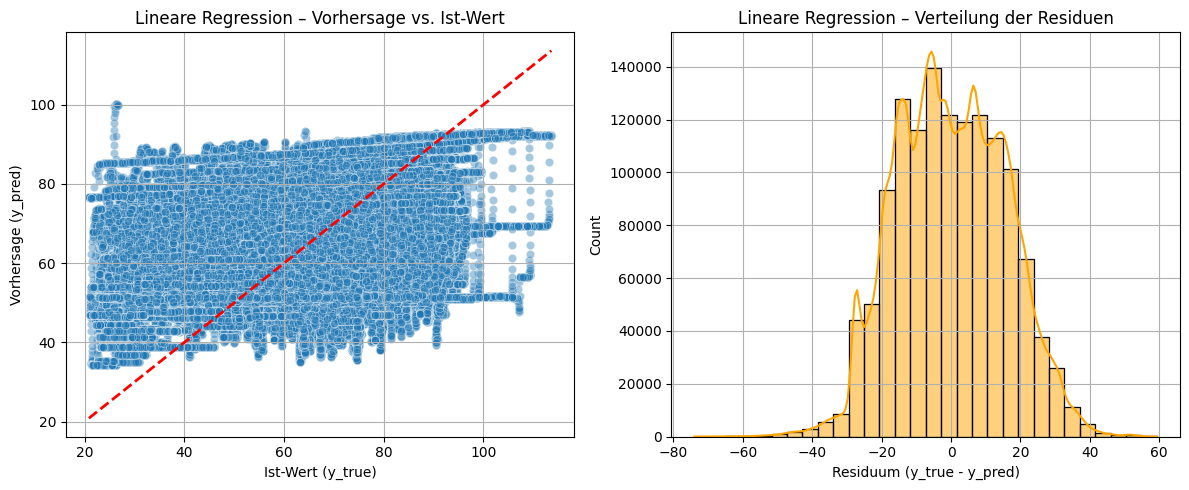

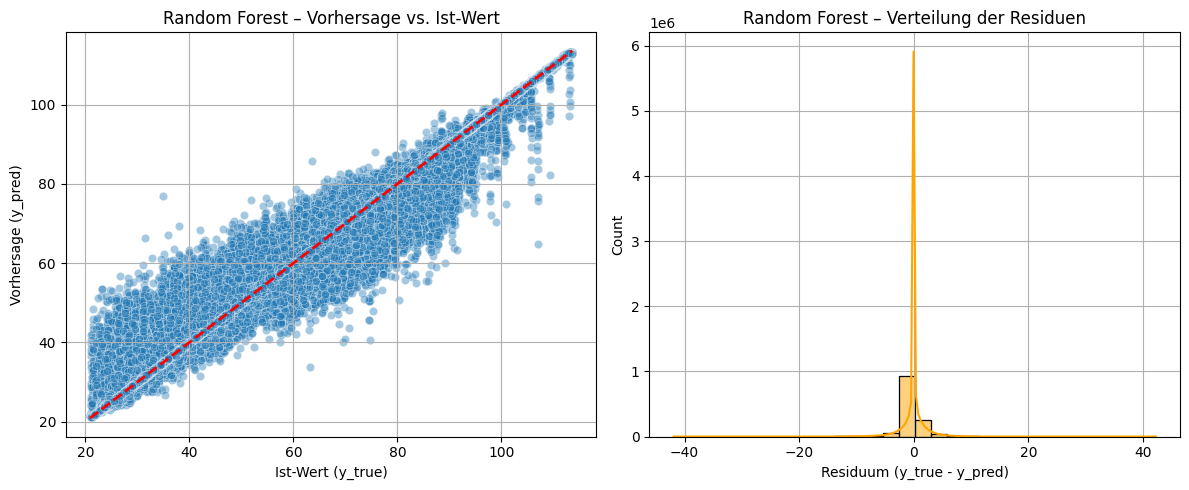

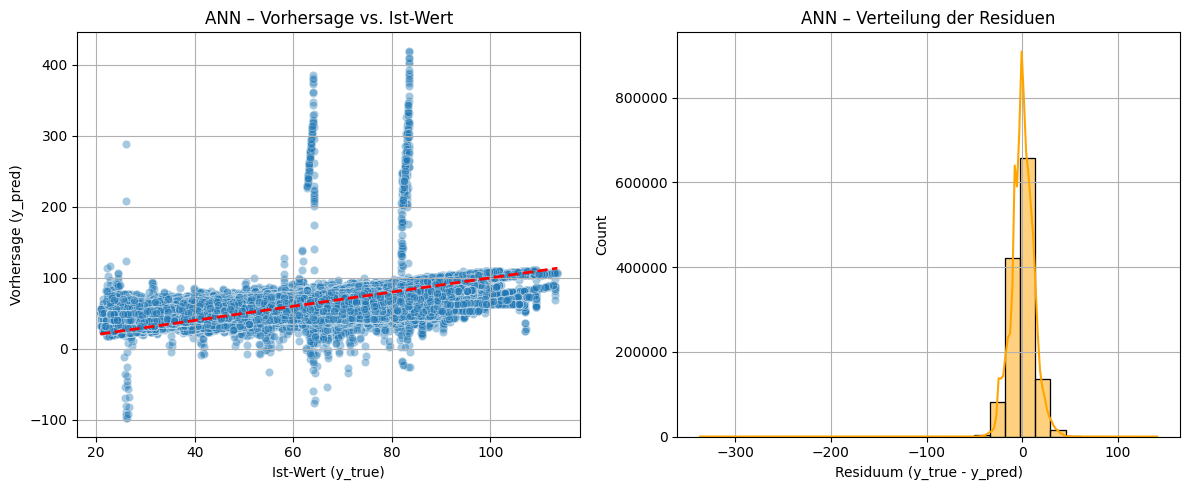

In [40]:
# Plot analysis for all 3 models
plot_model_diagnostics(motor_pm_labels, lin_reg_predictions, "Lineare Regression")

plot_model_diagnostics(motor_pm_labels, forest_predictions, "Random Forest")

plot_model_diagnostics(motor_pm_labels, ann_predictions, "ANN")

# <span style="color: RED;">TODO</span>
Schlussfolgerung
Ziel: Herausfinden, wo dein Modell Schwächen hat – z. B. bei Randwerten, Ausreißern oder bestimmten Bedingungen.

---
### 6. Feintuning der Modelle


#### Hyperparameter-Tuning

Zur effizienten Optimierung der Modellparameter wird ein zweistufiges Verfahren verwendet um für alle drei Modelle die besten Parameter zu finden.

1. **RandomizedSearchCV**  
   → Grobe Erkundung des Hyperparameterraums bei geringem Rechenaufwand  

2. **GridSearchCV (optional)**  
   → Feintuning auf Basis der vielversprechendsten Parameterbereiche aus Schritt 1  
   → Zielgerichtete Optimierung mit eng gesetztem Parameter-Grid


#### Modell 1: Lineare Regression

Bei der linearen Regression wird nur der Hyperparameter `add_current_magnitude` überprüft. Ein **RandomizedSearchCV** ist daher hier noch nicht notwendig/sinvoll. Stattdessen wird direkt mit einem **GridSearchCV** nach dem besten Parameter-Wert gesucht.

Unabhängig davon werden die **Temperaturmerkmale immer entfernt**, da die Zielsetzung explizit vorsieht, ein Modell ohne temperaturabhängige Eingangsdaten zu entwickeln.

Bezüglich der **Feature-Engineering-Komponente `current_magnitude`** zeigte die Analyse der Feature-Relevanz keine eindeutige Tendenz. Daher wird der Nutzen im Rahmen des Hyperparameter-Tunings explizit getestet.

Aufgrund der verfügbaren Rechenresourcen wird die Evauation auf 3 Folds begrenzt.

In [41]:
param_grid = {
    "regressor": [LinearRegression()],
    "magnitude_attrib_adder__add_current_magnitude": [True, False], # Try prediction with and without the extra Feature
}

lin_reg_grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)

lin_reg_grid_search.fit(motor, motor_pm_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_dropper', FeatureDropper()),
                                       ('magnitude_attrib_adder',
                                        CurrentMagnitudeAdder()),
                                       ('std_scaler', StandardScaler()),
                                       ('regressor', None)]),
             param_grid={'magnitude_attrib_adder__add_current_magnitude': [True,
                                                                           False],
                         'regressor': [LinearRegression()]},
             return_train_score=True, scoring='neg_mean_squared_error')

Dies ergibt **2 Modellkonfigurationen**, die jeweils mit 5-facher Cross-Validation bewertet werden.

In [42]:

# Utility function to print the best parameters and corresponding RMSE from a fitted GridSearchCV or RandomizedSearchCV object
def print_search_summary(search_cv):
    """
    Prints the best parameter combination and corresponding RMSE 
    from a fitted GridSearchCV or RandomizedSearchCV object.
    
    Parameters:
        search_cv: A fitted instance of sklearn.model_selection.GridSearchCV 
                   or sklearn.model_selection.RandomizedSearchCV
    """
    print("\nBeste Parameterkombination:")
    for key, value in search_cv.best_params_.items():
        print(f"  {key}: {value}")

    # Calculate and print best RMSE from best_score_ (which is negative MSE)
    best_rmse = np.sqrt(-search_cv.best_score_)
    print(f"\nBester RMSE (basierend auf Cross-Validation): {best_rmse:.3f}")
    
    return {
        "best_params": search_cv.best_params_,
        "best_rmse": best_rmse,
    }

In [43]:
grid_tuned_lin_reg = print_search_summary(lin_reg_grid_search)


Beste Parameterkombination:
  magnitude_attrib_adder__add_current_magnitude: True
  regressor: LinearRegression()

Bester RMSE (basierend auf Cross-Validation): 15.625


Die Lineare Regression kommt also **mit** dem Feature `current_magnitude` auf etwas bessere Vorhersagen (RMSE: 15,63 satt 15,73).

#### Modell 2: Random Forest (Target Methode)

Im ersten Schritt kommt `RandomizedSearchCV` zum Einsatz. Dabei werden zufällig ausgewählte Kombinationen 
von Hyperparametern getestet – bei geringem Rechenaufwand. Dieser Ansatz ist besonders effizient, 
wenn nur eine  begrenzt Anzahl Modelltrainings durchführen kann/soll.

Parameter:

 - `n_estimators`: Anzahl der Entscheidungsbäume
 - `max_features`: Anzahl der Features, die für jeden Split berücksichtigt werden
 - `n_iter`: Anzahl zufällige Kombinationen aus dem Parameterraum (Aufgrund geringer Rechenresourcen eingegrenzt)
 - `cv`: Anzahl der Folds in der Corss-Validation. (Aufgrund geringer Rechenresourcen stark eingegrenzt)

In [44]:
param_distribs = {
    "regressor": [RandomForestRegressor(random_state=42)],
    "regressor__n_estimators": randint(low=1, high=10),
    "regressor__max_features": randint(low=1, high=7),  # 1 to all Features
}

forest_rnd_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribs,
    n_iter=10,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
)
forest_rnd_search.fit(motor, motor_pm_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feature_dropper',
                                              FeatureDropper()),
                                             ('magnitude_attrib_adder',
                                              CurrentMagnitudeAdder()),
                                             ('std_scaler', StandardScaler()),
                                             ('regressor', None)]),
                   param_distributions={'regressor': [RandomForestRegressor(random_state=42)],
                                        'regressor__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024112C42890>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024112CEB190>},
                   random_state=42, scoring='neg_mean_squared_error')

In [45]:
rnd_tuned_forest = print_search_summary(forest_rnd_search)


Beste Parameterkombination:
  regressor: RandomForestRegressor(random_state=42)
  regressor__max_features: 4
  regressor__n_estimators: 8

Bester RMSE (basierend auf Cross-Validation): 5.057


Auf Basis der Ergebnisse mit **RandomizedSearchCV** wird nun ein eingeschränkter, sinnvoller Parameterbereich definiert, der gezielt mit **GridSearchCV** für jedes Modell durchgetestet wird. Anstelle von zufälligen Parameter-werten, werden jetzt also spezifische Kombinationen getestet.

Unabhängig davon werden die **Temperaturmerkmale immer entfernt**, da die Zielsetzung explizit vorsieht, ein Modell ohne temperaturabhängige Eingangsdaten zu entwickeln.

Bezüglich der **Feature-Engineering-Komponente `current_magnitude`** zeigte die Analyse der Feature-Relevanz keine eindeutige Tendenz. Daher wird der Nutzen im Rahmen des Hyperparameter-Tunings explizit getestet.

In [46]:
param_grid = {
    "regressor": [RandomForestRegressor(random_state=42)],
    "regressor__n_estimators": [5, 7],
    "regressor__max_features": [3, 7],
    "magnitude_attrib_adder__add_current_magnitude": [True, False],
}

forest_grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
forest_grid_search.fit(motor, motor_pm_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_dropper', FeatureDropper()),
                                       ('magnitude_attrib_adder',
                                        CurrentMagnitudeAdder()),
                                       ('std_scaler', StandardScaler()),
                                       ('regressor', None)]),
             param_grid={'magnitude_attrib_adder__add_current_magnitude': [True,
                                                                           False],
                         'regressor': [RandomForestRegressor(random_state=42)],
                         'regressor__max_features': [3, 7],
                         'regressor__n_estimators': [5, 7]},
             return_train_score=True, scoring='neg_mean_squared_error')

Dies ergibt **A × B × C = D Modellkonfigurationen**, die jeweils mit 3-facher Cross-Validation bewertet werden.

In [47]:
grid_tuned_forest = print_search_summary(forest_grid_search)


Beste Parameterkombination:
  magnitude_attrib_adder__add_current_magnitude: True
  regressor: RandomForestRegressor(random_state=42)
  regressor__max_features: 7
  regressor__n_estimators: 7

Bester RMSE (basierend auf Cross-Validation): 4.958


#### Modell 3: Artificial Neural Network (ANN)

Analog zu den vorherigen Modellen folgt nun das hyperparametertuning des neuronalen Netzes. 

Parameter:

 - `hidden_layer_sizes`: Definiert die Struktur des Netzes (Neuronen, Schichten)
 - `alpha`: L2 Regularisierungsparameter. Beeinflusst Over-/Underfitting
 - `cv`und `n_iter` Aufgrund der verfügbaren Resourcen noch stärker reduziert (Random Forest scheint ein vielversprechenderes Modell zu sein)

In [48]:
param_distribs = {
    "regressor": [MLPRegressor(random_state=42, max_iter=300)],
    "regressor__hidden_layer_sizes": [(5,), (10,), (20,), (50,), (100,)],
    "regressor__alpha": uniform(0.001, 0.01)
}

ann_rnd_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distribs,
    n_iter=4,
    cv=3,
    scoring="neg_mean_squared_error",
    random_state=42,
)
ann_rnd_search.fit(motor, motor_pm_labels)


c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine L

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feature_dropper',
                                              FeatureDropper()),
                                             ('magnitude_attrib_adder',
                                              CurrentMagnitudeAdder()),
                                             ('std_scaler', StandardScaler()),
                                             ('regressor', None)]),
                   n_iter=4,
                   param_distributions={'regressor': [MLPRegressor(max_iter=300,
                                                                   random_state=42)],
                                        'regressor__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000024112DBBFD0>,
                                        'regressor__hidden_layer_sizes': [(5,),
                                                                          (10,),
                                                                          (20,),
                                                                          (50,),
                                                                          (100,)]},
                   random_state=42, scoring='neg_mean_squared_error')

In [49]:
rnd_tuned_ann = print_search_summary(ann_rnd_search)


Beste Parameterkombination:
  regressor: MLPRegressor(max_iter=300, random_state=42)
  regressor__alpha: 0.0028343478986616382
  regressor__hidden_layer_sizes: (100,)

Bester RMSE (basierend auf Cross-Validation): 7.309


Auf Basis der Ergebnisse mit **RandomizedSearchCV** wird nun ein eingeschränkter, sinnvoller Parameterbereich definiert, der gezielt mit **GridSearchCV** für jedes Modell durchgetestet wird.

In [ ]:
param_grid = {
    "regressor": [MLPRegressor(random_state=42, max_iter=300)],
    "regressor__hidden_layer_sizes": [(5,), (10,)],
    "regressor__alpha": [0.0005, 0.001],  # Regularization
    "magnitude_attrib_adder__add_current_magnitude": [True, False],
}

ann_grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
ann_grid_search.fit(motor, motor_pm_labels)


c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine Learning\Practical Lectures\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\fynnb\OneDrive\Dokumente\BUHL\TH_Koeln_PC\Vorlesung\Machine L

Dies ergibt **A × B × C = D Modellkonfigurationen**, die jeweils mit 3-facher Cross-Validation bewertet werden.

In [ ]:
grid_tuned_ann = print_search_summary(ann_grid_search)

#### Modell Vergleich

Nach dem Feintuning der drei Modelle ergeben sich die folgenden RMSE-Werte:

In [ ]:
pd.set_option("display.max_colwidth", None)
def format_params(params):
    return pprint.pformat(params, compact=True)

# Dictionary with the summarized values
summary = {
    "Linear Regression": {
        "Best RMSE": grid_tuned_lin_reg["best_rmse"],
        "Best Params": grid_tuned_lin_reg["best_params"],
    },
    "Random Forest": {
        "Best RMSE": grid_tuned_forest["best_rmse"],
        "Best Params": grid_tuned_forest["best_params"],
    },
    "ANN": {
        "Best RMSE": grid_tuned_ann["best_rmse"],
        "Best Params": grid_tuned_ann["best_params"],
    }
}

results_post = pd.DataFrame.from_dict(summary, orient='index')
display(results_post)

# <span style="color: RED;">TODO</span>

Zusammenfassung tabelle

#### Modellwahl und finale Evaluation

Das Modell **XXX** zeigt mit YYY die besten Ergebnisse mit dem geringsten Fehler im Vergleich zu den Alternativen.
Zur Abschätzung des Generalisierungsfehlers wird das finale Modell abschließend auf dem separaten Testdatensatz evaluiert. 


In [ ]:
final_model = forest_grid_search.best_estimator_

X_test = strat_test_set.drop("pm", axis=1)
y_test = strat_test_set["pm"].copy()

# The 'final_model' is a trained Pipeline from GridSearchCV's best_estimator_.
# When 'predict()' is called, its internal transformers
# automatically use their 'transform()' method [not 'fit_transform()'].
# Thus, 'X_test' should be the raw, untransformed test data.
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_mae = mean_absolute_error(y_test, final_predictions)

print(f"Finaler RMSE: {final_rmse:.3f}")
print(f"Finaler MAE:  {final_mae:.3f}")

# <span style="color: RED;">TODO</span>
Schlussfolgerung

Ein einzelner Fehlerwert (MAE oder RMSE) reicht oft nicht aus, um eine fundierte Entscheidung über den Einsatz eines neuen Modells zu treffen. Um die Aussagekraft der Fehlerkennzahl besser einschätzen zu können, wird zusätzlich das **95% Konfidenzintervall** berechnet.  
Es ibt an, in welchem Bereich der wahre Generalisierungsfehler mit hoher Wahrscheinlichkeit liegt.


In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

Das 95% Konfidenzintervall für den RMSE gibt den Wertebereich an, in dem der wahre RMSE mit 95%iger Sicherheit liegt. Es berücksichtigt die Stichprobenvarianz und zeigt die Präzision der RMSE-Schätzung.

# <span style="color: RED;">TODO</span>
Schlussfolgerung

---
# <span style="color: RED;">TODO</span>
### 7. Abschließende Zusammenfassung

1. Document what you have done.
    - write a summary of the results in a new, final section
    - explain why your solution achieves the task objective
